## Análise de sentimento em tweets

In [120]:
# Todos os imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## 1 - Carregamento dos dados e EDA inicial

**1.1.** (Carregamento)
Baixe e carregue os dados a partir do Kaggle

In [2]:
# Carregamento do arquivo, baixei no site e carreguei aqui. Para info estou usando o vscode...
arquivo = "Tweets.csv"
dados_tweets = pd.read_csv(arquivo)

dados_tweets

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


**1.2.** Crie a variável alvo conforme a Tabela 1 e salve no dataset (por exemplo como target)

In [3]:
# Fazendo mapeamento dos sentimentos para os valores alvo
sentimento_alvo = {'negative': 1, 'neutral': 0, 'positive': 0}
dados_tweets['target'] = dados_tweets['sentiment'].map(sentimento_alvo)

# Exibir o "target"
print(dados_tweets.target)

0        0
1        1
2        1
3        1
4        1
        ..
27476    1
27477    1
27478    0
27479    0
27480    0
Name: target, Length: 27481, dtype: int64


**1.3.** (EDA inicial)
Observe se existem dados faltantes ou duplicados

In [4]:
# Verificando se há dados faltantes
dados_faltantes = dados_tweets.isnull().sum()
print("Dados faltantes no dataset:")
print(dados_faltantes)

Dados faltantes no dataset:
textID           0
text             1
selected_text    1
sentiment        0
target           0
dtype: int64


In [5]:
# Verificando se há dados duplicados
dados_duplicados = dados_tweets[dados_tweets.duplicated()]
# Mostrando os dados duplicados, se houver
if not dados_duplicados.empty:
    print("Dados duplicados no dataset:")
    print(dados_duplicados)
else:
    print("Não há dados duplicados no dataset.")
    
# Não existem dados duplicados

Não há dados duplicados no dataset.


**1.4.** Plote um histograma do número dos caracteres dos reviews

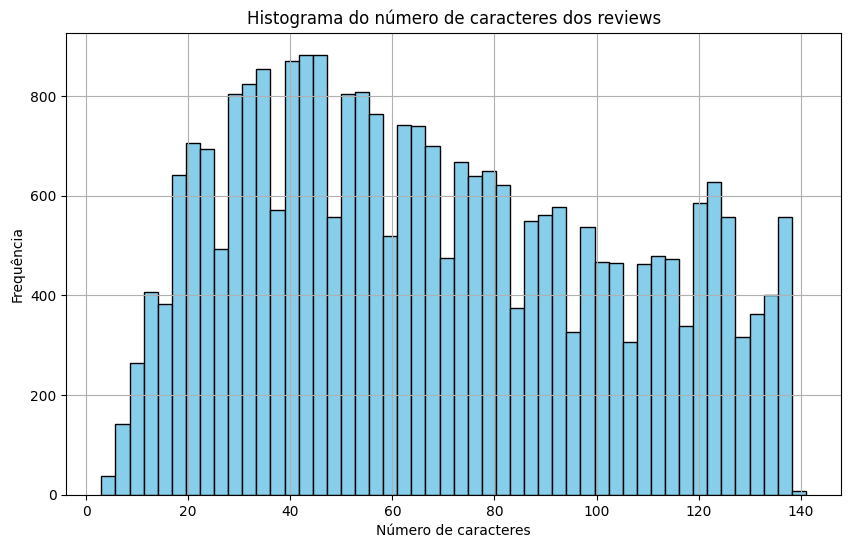

In [6]:
# Calculando o número de caracteres em cada texto
dados_tweets['num_caracteres'] = dados_tweets['text'].apply(lambda x: len(str(x)))

# Plotando o histograma
plt.figure(figsize=(10, 6))
plt.hist(dados_tweets['num_caracteres'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Número de caracteres')
plt.ylabel('Frequência')
plt.title('Histograma do número de caracteres dos reviews')
plt.grid(True)
plt.show()

**1.5.** Plote um histograma do número de palavras dos reviews

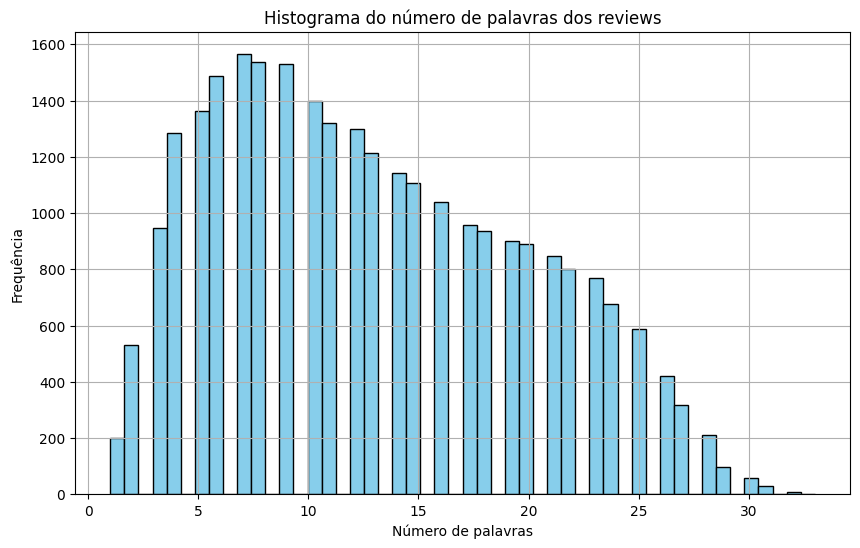

In [7]:
# Calculando o número de palavras em cada review
dados_tweets['num_palavras'] = dados_tweets['text'].apply(lambda x: len(str(x).split()))

# Plotando o histograma
plt.figure(figsize=(10, 6))
plt.hist(dados_tweets['num_palavras'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.title('Histograma do número de palavras dos reviews')
plt.grid(True)
plt.show()

**1.6.** Mostre os 5 maiores e menores comentários e o sentimento relacionado

In [8]:
# Ordem pelo número de palavras, ascending=False para ordenar em ordem decrescente
dados_tweets_ordenado = dados_tweets.sort_values(by='num_palavras', ascending=False)

# 5 maiores comentários com o sentimento relacionado, topo
print("Os 5 maiores comentários:")
print(dados_tweets_ordenado[['text', 'sentiment']].head(5))

# 5 menores comentários com o sentimento relacionado, fundo (calda)
print("\nOs 5 menores comentários:")
print(dados_tweets_ordenado[['text', 'sentiment']].tail(5))

Os 5 maiores comentários:
                                                    text sentiment
19887  AK, flop comes 2K6 I bet 15 get raised to 25 I...   neutral
25359  : Lol it went okay! As far as I can tell . But...  positive
8149   ummmm i have no idea what im doing but my frie...  negative
10383  This is exactly y I hate driving thru dandy - ...  negative
6737   First Happy Mothers Day  Second what is it tha...  positive

Os 5 menores comentários:
               text sentiment
23482       Work...   neutral
814          Night!   neutral
23412      starbuck   neutral
23387       Boreedd  negative
14311  CoNvErSaTiNg   neutral


**1.7.**  Mostre um WordCloud com todo o texto dos reviews (utilize a função WordCloud da biblioteca wordcloud)

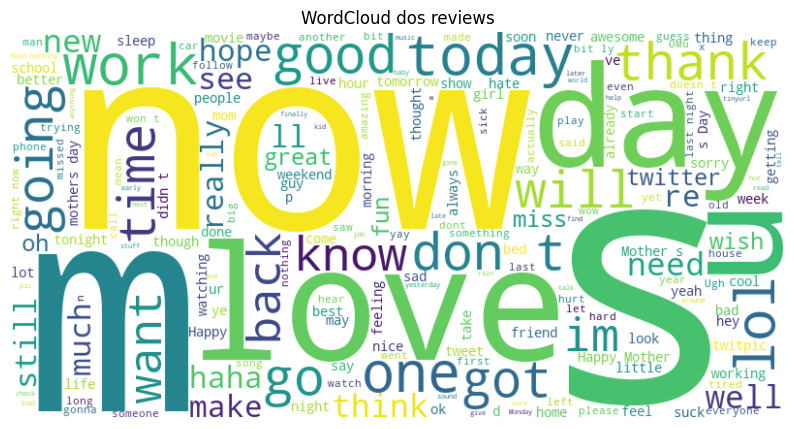

In [9]:
# Tive que fazer uma copia pois vou usar astype, e isso gerava problema futuramente no item 2.2, pois dados faltantes seriam substituídos por string vazia
dados_tweets_wordcloud = dados_tweets.copy()

# Tem valores float no meio dos textos, astype para contornar isso
dados_tweets_wordcloud['text'] = dados_tweets_wordcloud['text'].astype(str)

# Concatenando todos os textos em uma única string
todos_textos = ' '.join(dados_tweets_wordcloud['text'])

# Criando o objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(todos_textos)

# Plotando o WordCloud, fica bem bonito
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dos reviews')
plt.show()

**1.7.a.** Repita somente para os comentários negativos

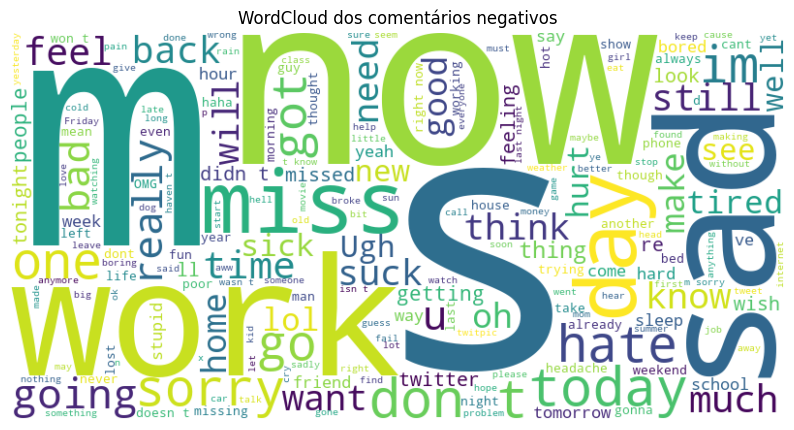

In [10]:
# Filtrando os comentários negativos
comentarios_negativos = dados_tweets_wordcloud[dados_tweets_wordcloud['sentiment'] == 'negative']

# Concatenando os textos negativos
textos_negativos = ' '.join(comentarios_negativos['text'])

# WordCloud negativos
wordcloud_negativos = WordCloud(width=800, height=400, background_color='white').generate(textos_negativos)

# Plotando o WordCloud para os comentários negativos
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negativos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dos comentários negativos')
plt.show()

**1.7.b.** Repita somente para os comentários neutros

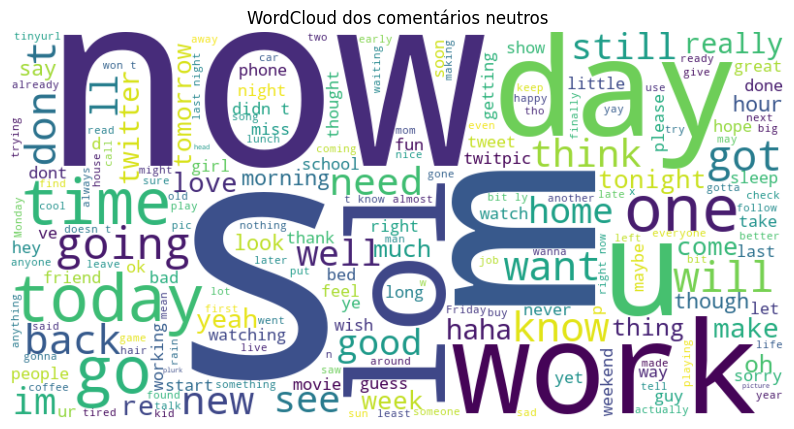

In [11]:
# Filtrando os comentários neutros
comentarios_neutros = dados_tweets_wordcloud[dados_tweets_wordcloud['sentiment'] == 'neutral']

# Concatenando os textos neutros
textos_neutros = ' '.join(comentarios_neutros['text'])

# WordCloud neutros
wordcloud_neutros = WordCloud(width=800, height=400, background_color='white').generate(textos_neutros)

# Plotando o WordCloud para os comentários neutros
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_neutros, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dos comentários neutros')
plt.show()

**1.7.c.** Repita somente para os comentários positivos

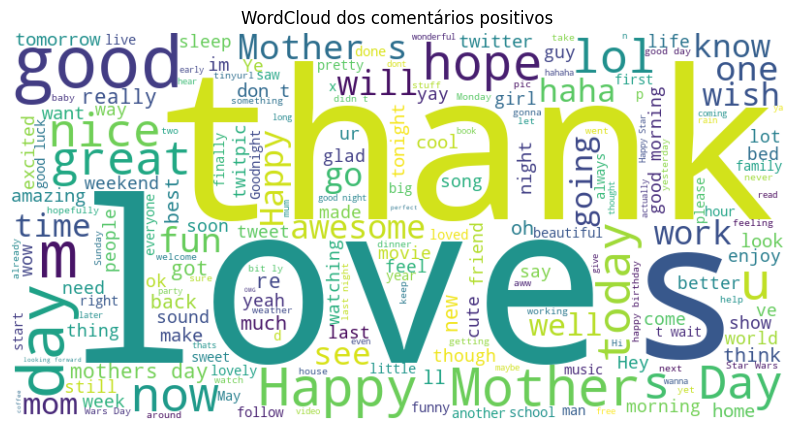

In [12]:
# Filtrando os comentários positivos
comentarios_positivos = dados_tweets_wordcloud[dados_tweets_wordcloud['sentiment'] == 'positive']

# Concatenando os textos positivos
textos_positivos = ' '.join(comentarios_positivos['text'])

# WordCloud positivos
wordcloud_positivos = WordCloud(width=800, height=400, background_color='white').generate(textos_positivos)

# Plotando o WordCloud para os comentários positivos
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positivos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dos comentários positivos')
plt.show()

**1.8.** Mostre a distribuição da variável alvo através de um gráfico de barras

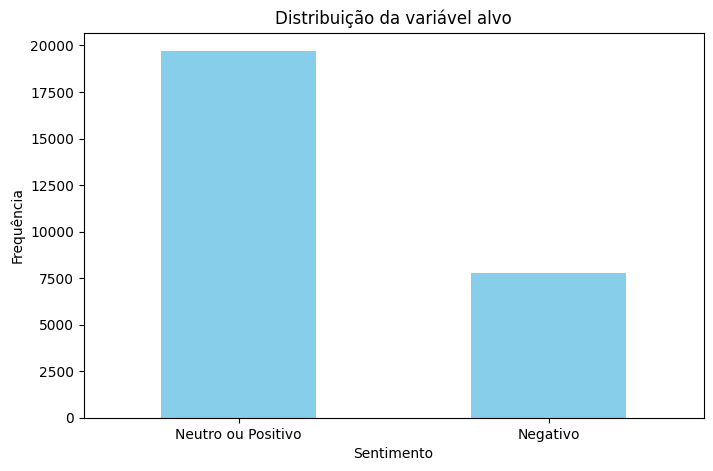

In [13]:
# Contando o número de ocorrências de target
contagem_target = dados_tweets['target'].value_counts()

# Plotando o gráfico de barras para a distribuição da variável alvo
plt.figure(figsize=(8, 5))
contagem_target.plot(kind='bar', color='skyblue')
plt.xlabel('Sentimento')
plt.ylabel('Frequência')
plt.title('Distribuição da variável alvo')
plt.xticks([0, 1], ['Neutro ou Positivo', 'Negativo'], rotation=0)
plt.show()

**1.8.a.** Repita mostrando a distribuição dos sentimentos originais (negativo, positivo e neutro)

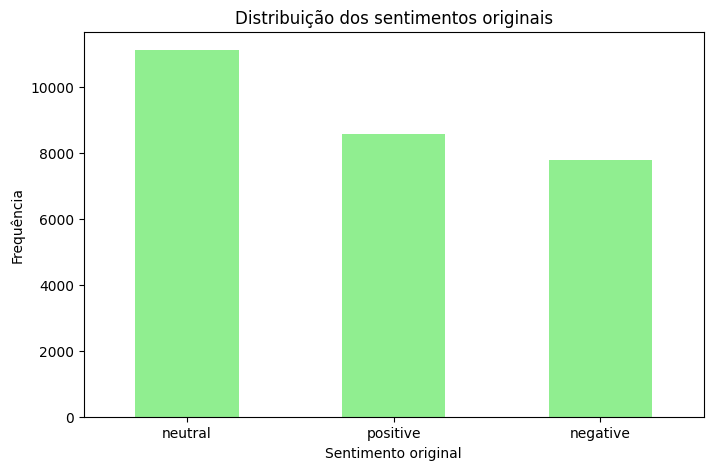

In [14]:
# Contando o número de ocorrências de sentiment
contagem_sentimento = dados_tweets['sentiment'].value_counts()

# Plotando o gráfico de barras para a distribuição dos sentimentos originais
plt.figure(figsize=(8, 5))
contagem_sentimento.plot(kind='bar', color='lightgreen')
plt.xlabel('Sentimento original')
plt.ylabel('Frequência')
plt.title('Distribuição dos sentimentos originais')
plt.xticks(rotation=0)
plt.show()

## 2 - Limpeza e separação dos dados

**2.1.** Remova as colunas extra do dataset, deixando somente as colunas text e target

In [15]:
# Removendo as colunas
dados_tweets = dados_tweets[['text', 'target']]

# Verificando se as colunas foram removidas corretamente
print(dados_tweets.head())

                                                text  target
0                I`d have responded, if I were going       0
1      Sooo SAD I will miss you here in San Diego!!!       1
2                          my boss is bullying me...       1
3                     what interview! leave me alone       1
4   Sons of ****, why couldn`t they put them on t...       1


**2.2.** (Se necessário) Trate os dados faltantes ou duplicados (Split)

In [16]:
# Criei uma cópia pois o terminal ficava dando warning sobre usar o dropna nos dados originais
dados_tweets_copy= dados_tweets.copy()

# Resolvi remover as linhas com valores nulos, pois são poucas
dados_tweets_copy.dropna(inplace=True)

# Verificando se ainda há valores nulos
dados_faltantes = dados_tweets.isnull().sum()
print("Dados faltantes no dataset original:")
print(dados_faltantes)
dados_faltantes_copy = dados_tweets_copy.isnull().sum()
print("Dados faltantes no novo dataset:")
print(dados_faltantes_copy)
print()
# Uma linha foi removida, antes tinha 27481 agora ficou 27480
dados_tweets_copy.info()

Dados faltantes no dataset original:
text      1
target    0
dtype: int64
Dados faltantes no novo dataset:
text      0
target    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27480 non-null  object
 1   target  27480 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 644.1+ KB


**2.3.** Separe 20% do conjunto para teste utilizando a divisão estratificada com base na coluna target

In [113]:
# Separando os recursos X e o alvo y
X = dados_tweets_copy['text']
y = dados_tweets_copy['target']

# Divisão estratificada com base na coluna target
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificando o shape dos conjuntos de treinamento e teste
print("Shape do conjunto de treino (X):", X_treino.shape)
print("Shape do conjunto de teste (X):", X_teste.shape)
print("Shape do conjunto de treino (y):", y_treino.shape)
print("Shape do conjunto de teste (y):", y_teste.shape)

Shape do conjunto de treino (X): (21984,)
Shape do conjunto de teste (X): (5496,)
Shape do conjunto de treino (y): (21984,)
Shape do conjunto de teste (y): (5496,)


**2.4.** Para o conjunto de validação, você pode escolher: ● Separar um conjunto hold-out; ou ● Fazer validação cruzada k-fold.

In [18]:
# Escolhi a validação cruzada k-fold

**2.5.** Separe os dados entre X e y para cada subconjunto de dados (X_train, y_train, X_val, y_val, X_test, y_test)

In [19]:
# Definindo o número de folds k, tinha começado com 5 mas demora muito pra rodar...
num_folds = 3

# Inicializando o objeto StratifiedKFold
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Realizando a validação cruzada k-fold
for fold, (train_index, val_index) in enumerate(kf.split(X_treino, y_treino), 1):
    print(f"Fold {fold}:")
    # Separando os dados de treinamento e validação para este fold
    X_train, X_val = X_treino.iloc[train_index], X_treino.iloc[val_index]
    y_train, y_val = y_treino.iloc[train_index], y_treino.iloc[val_index]
    # Imprimindo os tamanhos dos conjuntos de treinamento e validação
    print("Tamanho de X_train:", len(X_train))
    print("Tamanho de X_val:", len(X_val))
    print("Tamanho de y_train:", len(y_train))
    print("Tamanho de y_val:", len(y_val))

Fold 1:
Tamanho de X_train: 14656
Tamanho de X_val: 7328
Tamanho de y_train: 14656
Tamanho de y_val: 7328
Fold 2:
Tamanho de X_train: 14656
Tamanho de X_val: 7328
Tamanho de y_train: 14656
Tamanho de y_val: 7328
Fold 3:
Tamanho de X_train: 14656
Tamanho de X_val: 7328
Tamanho de y_train: 14656
Tamanho de y_val: 7328


Confirme que X é um array 1D (i.e., que você selecionou somente o texto como entrada e não outras variáveis)

In [20]:
# Confirmado
print(X.head())

0                  I`d have responded, if I were going
1        Sooo SAD I will miss you here in San Diego!!!
2                            my boss is bullying me...
3                       what interview! leave me alone
4     Sons of ****, why couldn`t they put them on t...
Name: text, dtype: object


## 3 - Seleção de hiperparâmetros

**3.1.** Nesta etapa, defina a pipeline de pré-processamento como sendo somente o CountVectorizer com seus parâmetros padrão

In [21]:
# Definindo a pipeline com o CountVectorizer
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer())
])

# Obtendo os nomes dos hiperparâmetros da pipeline
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'count_vectorizer', 'count_vectorizer__analyzer', 'count_vectorizer__binary', 'count_vectorizer__decode_error', 'count_vectorizer__dtype', 'count_vectorizer__encoding', 'count_vectorizer__input', 'count_vectorizer__lowercase', 'count_vectorizer__max_df', 'count_vectorizer__max_features', 'count_vectorizer__min_df', 'count_vectorizer__ngram_range', 'count_vectorizer__preprocessor', 'count_vectorizer__stop_words', 'count_vectorizer__strip_accents', 'count_vectorizer__token_pattern', 'count_vectorizer__tokenizer', 'count_vectorizer__vocabulary'])

**3.2.** Regressão Logística: 
a. Treine um modelo de regressão logística com os parâmetros padrão

In [23]:
# Criando a pipeline com CountVectorizer e Regressão Logística usando parâmetros padrão
pipeline_log_reg = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('logistic_regression', LogisticRegression(max_iter=1000))
])

# Ajustanado o pipeline aos dados de treinamento
pipeline_log_reg.fit(X_train, y_train)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino = pipeline_log_reg.predict(X_train)
predicoes_validacao = pipeline_log_reg.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino = balanced_accuracy_score(y_train, predicoes_treino)
acuracia_validacao = balanced_accuracy_score(y_val, predicoes_validacao)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao * 100))

# Percebe-se que com os hiperparâmetros padrão ocorre um pouco de overshooting pois o modelo se adequou melhor ao treino que na validação.


Acurácia treino:    89.30%
Acurácia validação: 73.96%


**3.2.b.** Realize a otimização de hiperparâmetros

In [25]:
# Definindo uma grade de hiperparâmetros para a otimização
param_grid_log_reg = {
    'logistic_regression__C': [0.6, 0.7, 0.8],
    'logistic_regression__solver': ['liblinear'],
    'logistic_regression__penalty': ['l1'],
    'count_vectorizer__max_features': [2100, 2200, 2300],
    'logistic_regression__tol': [1e-4, 1e-3, 10e-2],
    'logistic_regression__class_weight': [None],
}

# Criando uma nova instância do GridSearchCV para a otimização
grid_search_log_reg = GridSearchCV(pipeline_log_reg, param_grid_log_reg, cv=num_folds, verbose=1)

# Ajustanado o pipeline aos dados de treinamento
grid_search_log_reg.fit(X_train, y_train)
print(grid_search_log_reg.best_params_)
print()

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino = grid_search_log_reg.predict(X_train)
predicoes_validacao = grid_search_log_reg.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino = balanced_accuracy_score(y_train, predicoes_treino)
acuracia_validacao = balanced_accuracy_score(y_val, predicoes_validacao)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao * 100))

# Ajustando alguns hiperparâmetros consegui remover o overshooting, porém a acurácia de validação teve uma melhora muito pequena.

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'count_vectorizer__max_features': 2200, 'logistic_regression__C': 0.7, 'logistic_regression__class_weight': None, 'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'liblinear', 'logistic_regression__tol': 0.1}


Acurácia treino:    79.24%
Acurácia validação: 74.72%


**3.3.a.** SVM com kernel RBF

In [37]:
# Criando a pipeline com CountVectorizer e SVM com kernel RBF
pipeline_svm_rbf = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('svm', SVC(kernel='rbf'))
])

# Ajustando o pipeline aos dados de treinamento
pipeline_svm_rbf.fit(X_train, y_train)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_svm_rbf = pipeline_svm_rbf.predict(X_train)
predicoes_validacao_svm_rbf = pipeline_svm_rbf.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_svm_rbf = balanced_accuracy_score(y_train, predicoes_treino_svm_rbf)
acuracia_validacao_svm_rbf = balanced_accuracy_score(y_val, predicoes_validacao_svm_rbf)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_svm_rbf * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_svm_rbf * 100))

# Percebe-se que com os hiperparâmetros padrão ocorre overshooting pois o modelo se adequou melhor ao treino que na validação.


Acurácia treino:    88.68%
Acurácia validação: 68.21%


**3.3.b.** Realize a otimização de hiperparâmetros

In [45]:
# Definindo uma grade de hiperparâmetros para a otimização do SVM com kernel RBF
param_grid_svm_rbf = {
    'svm__C': [0.8, 1.0, 1.2],
    'svm__gamma': ['scale', 'auto', 0.1],
    'svm__class_weight': [None, 'balanced']
}

# Criando uma nova instância do GridSearchCV para a otimização do SVM com kernel RBF
grid_search_svm_rbf = GridSearchCV(pipeline_svm_rbf, param_grid_svm_rbf, cv=num_folds, verbose=1)

# Ajustando o pipeline aos dados de treinamento
grid_search_svm_rbf.fit(X_train, y_train)
print(grid_search_svm_rbf.best_params_)
print()

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_svm_rbf = grid_search_svm_rbf.predict(X_train)
predicoes_validacao_svm_rbf = grid_search_svm_rbf.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_svm_rbf = balanced_accuracy_score(y_train, predicoes_treino_svm_rbf)
acuracia_validacao_svm_rbf = balanced_accuracy_score(y_val, predicoes_validacao_svm_rbf)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_svm_rbf * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_svm_rbf * 100))

# Esse é o mais demorado pra rodar, então parei nesses parâmetros, aumentou o overshooting mas também aumentou a acurácia de validação.

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'svm__C': 1.2, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale'}


Acurácia treino:    96.91%
Acurácia validação: 75.32%


**3.4.** Árvore de Decisão

In [26]:
# Criando a pipeline com CountVectorizer e Árvore de Decisão
pipeline_decision_tree = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('decision_tree', DecisionTreeClassifier())
])

# Ajustando o pipeline aos dados de treinamento
pipeline_decision_tree.fit(X_train, y_train)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_dt = pipeline_decision_tree.predict(X_train)
predicoes_validacao_dt = pipeline_decision_tree.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_dt = balanced_accuracy_score(y_train, predicoes_treino_dt)
acuracia_validacao_dt = balanced_accuracy_score(y_val, predicoes_validacao_dt)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_dt * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_dt * 100))

# Percebe-se que com os hiperparâmetros padrão ocorre muito overshooting pois o modelo se adequou melhor ao treino que na validação.


Acurácia treino:    99.96%
Acurácia validação: 71.41%


**3.4.b.** Realize a otimização de hiperparâmetros

In [72]:
# Definindo uma grade de hiperparâmetros para a otimização da Árvore de Decisão
param_grid_decision_tree = {
    'decision_tree__min_samples_split': [2, 5, 10],
    'count_vectorizer__max_features': [1700, 1800, 1900],
    'decision_tree__max_features': ['sqrt', 'log2'],
}

# Criando uma nova instância do GridSearchCV para a otimização da Árvore de Decisão
grid_search_decision_tree = GridSearchCV(pipeline_decision_tree, param_grid_decision_tree, cv=num_folds, verbose=1)

# Ajustando o pipeline aos dados de treinamento
grid_search_decision_tree.fit(X_train, y_train)
print(grid_search_decision_tree.best_params_)
print()

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_dt = grid_search_decision_tree.predict(X_train)
predicoes_validacao_dt = grid_search_decision_tree.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_dt = balanced_accuracy_score(y_train, predicoes_treino_dt)
acuracia_validacao_dt = balanced_accuracy_score(y_val, predicoes_validacao_dt)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_dt * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_dt * 100))

# Esse foi o com pior desempenho, não consegui melhorar a acurácia mudando os hiperparâmetros.

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'count_vectorizer__max_features': 1900, 'decision_tree__max_features': 'sqrt', 'decision_tree__min_samples_split': 10}


Acurácia treino:    89.08%
Acurácia validação: 67.71%


**3.5.** Floresta Aleatória

In [46]:
# Criando a pipeline com CountVectorizer e Floresta Aleatória
pipeline_random_forest = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('random_forest', RandomForestClassifier())
])

# Ajustando a pipeline aos dados de treinamento
pipeline_random_forest.fit(X_train, y_train)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_rf = pipeline_random_forest.predict(X_train)
predicoes_validacao_rf = pipeline_random_forest.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_rf = balanced_accuracy_score(y_train, predicoes_treino_rf)
acuracia_validacao_rf = balanced_accuracy_score(y_val, predicoes_validacao_rf)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_rf * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_rf * 100))

# Percebe-se que com os hiperparâmetros padrão ocorre muito overshooting pois o modelo se adequou melhor ao treino que na validação.


Acurácia treino:    99.97%
Acurácia validação: 69.47%


**3.5.b.** Realize a otimização de hiperparâmetros

In [57]:
# Definindo uma grade de hiperparâmetros para a otimização da Floresta Aleatória
param_grid_random_forest = {
    'random_forest__n_estimators': [100, 200, 300],
    'random_forest__max_depth': [None, 10, 20],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4]
}

# Criando uma nova instância do GridSearchCV para a otimização da Floresta Aleatória
grid_search_random_forest = GridSearchCV(pipeline_random_forest, param_grid_random_forest, cv=num_folds, verbose=1)

# Ajustando a pipeline aos dados de treinamento
grid_search_random_forest.fit(X_train, y_train)
print(grid_search_random_forest.best_params_)
print()

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_rf = grid_search_random_forest.predict(X_train)
predicoes_validacao_rf = grid_search_random_forest.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_rf = balanced_accuracy_score(y_train, predicoes_treino_rf)
acuracia_validacao_rf = balanced_accuracy_score(y_val, predicoes_validacao_rf)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_rf * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_rf * 100))

# Continua com overshooting mas melhorou um pouco a validação.

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'random_forest__max_depth': None, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 300}


Acurácia treino:    99.97%
Acurácia validação: 70.04%


**3.6**. Gradient Boosting

In [48]:
# Criando a pipeline com CountVectorizer e Gradient Boosting
pipeline_gb = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('gradient_boosting', GradientBoostingClassifier())
])

# Ajustando o pipeline aos dados de treinamento
pipeline_gb.fit(X_train, y_train)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_gb = pipeline_gb.predict(X_train)
predicoes_validacao_gb = pipeline_gb.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_gb = balanced_accuracy_score(y_train, predicoes_treino_gb)
acuracia_validacao_gb = balanced_accuracy_score(y_val, predicoes_validacao_gb)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_gb * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_gb * 100))

# O modelo não apresenta overshooting porém o desempenho é inferior comparado aos outros utilizando os hiperparâmetros padrão.


Acurácia treino:    64.71%
Acurácia validação: 63.10%


**3.6.b.** Realize a otimização de hiperparâmetros

In [49]:
# Definindo uma grade de hiperparâmetros para a otimização
param_grid_gb = {
    'gradient_boosting__n_estimators': [300, 400, 500],
    'gradient_boosting__learning_rate': [0.1, 0.2, 0.3],
    'count_vectorizer__max_features': [1400, 1500, 1600]
}

# Criando uma nova instância do GridSearchCV para a otimização
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=num_folds, verbose=1)

# Ajustando o pipeline aos dados de treinamento
grid_search_gb.fit(X_train, y_train)
print(grid_search_gb.best_params_)
print()

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_gb = grid_search_gb.predict(X_train)
predicoes_validacao_gb = grid_search_gb.predict(X_val)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_gb = balanced_accuracy_score(y_train, predicoes_treino_gb)
acuracia_validacao_gb = balanced_accuracy_score(y_val, predicoes_validacao_gb)

# Imprimindo as acurácias
print()
print("Acurácia treino:    {:.2f}%".format(acuracia_treino_gb * 100))
print("Acurácia validação: {:.2f}%".format(acuracia_validacao_gb * 100))

# Foi o que teve mais mudança em relação ao hiperparâmetros padrão e com os testados, melhorou bastante.

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'count_vectorizer__max_features': 1600, 'gradient_boosting__learning_rate': 0.2, 'gradient_boosting__n_estimators': 500}


Acurácia treino:    81.44%
Acurácia validação: 73.46%


## 4 - Retreinamento e resultados no conjunto de teste

4.1. Regressão Logística

**a.** Retreine o modelo com os melhores hiperparâmetros encontrados

**b**. Mostre a acurácia balanceada tanto no conjunto de treinamento (treinamento+validação) quanto no conjunto de teste

In [97]:
# Definindo uma grade de hiperparâmetros para a otimização
param_grid_log_reg = {
    'logistic_regression__C': 0.7,
    'logistic_regression__solver': 'liblinear',
    'logistic_regression__penalty': 'l1',
    'count_vectorizer__max_features': 2200,
    'logistic_regression__tol': 10e-2,
    'logistic_regression__class_weight': None
}

# Ajustanado o pipeline aos dados
pipeline_log_reg.set_params(**param_grid_log_reg)
pipeline_log_reg.fit(X_treino, y_treino)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino = pipeline_log_reg.predict(X_treino)
predicoes_validacao = pipeline_log_reg.predict(X_teste)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino = balanced_accuracy_score(y_treino, predicoes_treino)
acuracia_validacao = balanced_accuracy_score(y_teste, predicoes_validacao)

# Imprimindo as acurácias
print()
print("Acurácia treino + validação:    {:.2f}%".format(acuracia_treino * 100))
print("Acurácia validação:             {:.2f}%".format(acuracia_validacao * 100))


Acurácia treino + validação:    79.02%
Acurácia validação:             75.98%


4.2. SVM com kernel RBF

**a.** Retreine o modelo com os melhores hiperparâmetros encontrados

**b**. Mostre a acurácia balanceada tanto no conjunto de treinamento (treinamento+validação) quanto no conjunto de teste

In [101]:
# Definindo uma grade de hiperparâmetros para a otimização do SVM com kernel RBF
param_grid_svm_rbf = {
    'svm__C': 1.2,
    'svm__gamma': 'scale',
    'svm__class_weight': 'balanced'
}

# Ajustando o pipeline aos dados de treinamento
pipeline_svm_rbf.set_params(**param_grid_svm_rbf)
pipeline_svm_rbf.fit(X_treino, y_treino)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_svm_rbf = pipeline_svm_rbf.predict(X_treino)
predicoes_validacao_svm_rbf = pipeline_svm_rbf.predict(X_teste)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_svm_rbf = balanced_accuracy_score(y_treino, predicoes_treino_svm_rbf)
acuracia_validacao_svm_rbf = balanced_accuracy_score(y_teste, predicoes_validacao_svm_rbf)

# Imprimindo as acurácias
print()
print("Acurácia treino + validação:    {:.2f}%".format(acuracia_treino_svm_rbf * 100))
print("Acurácia validação:             {:.2f}%".format(acuracia_validacao_svm_rbf * 100))


Acurácia treino + validação:    96.73%
Acurácia validação:             76.47%


4.3. Árvore de Decisão

**a.** Retreine o modelo com os melhores hiperparâmetros encontrados

**b**. Mostre a acurácia balanceada tanto no conjunto de treinamento (treinamento+validação) quanto no conjunto de teste

In [98]:
# Definindo uma grade de hiperparâmetros para a otimização da Árvore de Decisão
param_grid_decision_tree = {
    'decision_tree__min_samples_split': 2,
    'count_vectorizer__max_features': 1800,
    'decision_tree__max_features': 'sqrt',
}

# Ajustando o pipeline aos dados de treinamento
pipeline_decision_tree.set_params(**param_grid_decision_tree)
pipeline_decision_tree.fit(X_treino, y_treino)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_dt = pipeline_decision_tree.predict(X_treino)
predicoes_validacao_dt = pipeline_decision_tree.predict(X_teste)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_dt = balanced_accuracy_score(y_treino, predicoes_treino_dt)
acuracia_validacao_dt = balanced_accuracy_score(y_teste, predicoes_validacao_dt)

# Imprimindo as acurácias
print()
print("Acurácia treino + validação:    {:.2f}%".format(acuracia_treino_dt * 100))
print("Acurácia validação:             {:.2f}%".format(acuracia_validacao_dt * 100))


Acurácia treino + validação:    99.70%
Acurácia validação:             68.23%


4.5. Floresta Aleatória

**a.** Retreine o modelo com os melhores hiperparâmetros encontrados

**b**. Mostre a acurácia balanceada tanto no conjunto de treinamento (treinamento+validação) quanto no conjunto de teste

In [99]:
# Definindo uma grade de hiperparâmetros para a otimização da Floresta Aleatória
param_grid_random_forest = {
    'random_forest__n_estimators': 300,
    'random_forest__max_depth': None,
    'random_forest__min_samples_split': 2,
    'random_forest__min_samples_leaf': 1
}

# Ajustando a pipeline aos dados de treinamento
pipeline_random_forest.set_params(**param_grid_random_forest)
pipeline_random_forest.fit(X_treino, y_treino)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_rf = pipeline_random_forest.predict(X_treino)
predicoes_validacao_rf = pipeline_random_forest.predict(X_teste)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_rf = balanced_accuracy_score(y_treino, predicoes_treino_rf)
acuracia_validacao_rf = balanced_accuracy_score(y_teste, predicoes_validacao_rf)

# Imprimindo as acurácias
print()
print("Acurácia treino + validação:    {:.2f}%".format(acuracia_treino_rf * 100))
print("Acurácia validação:             {:.2f}%".format(acuracia_validacao_rf * 100))


Acurácia treino + validação:    99.96%
Acurácia validação:             70.94%


4.6. Gradient Boosting

**a.** Retreine o modelo com os melhores hiperparâmetros encontrados

**b**. Mostre a acurácia balanceada tanto no conjunto de treinamento (treinamento+validação) quanto no conjunto de teste

In [100]:
# Definindo uma grade de hiperparâmetros para a otimização
param_grid_gb = {
    'gradient_boosting__n_estimators': 500,
    'gradient_boosting__learning_rate': 0.2,
    'count_vectorizer__max_features': 1600
}

# Ajustando o pipeline aos dados de treinamento
pipeline_gb.set_params(**param_grid_gb)
pipeline_gb.fit(X_treino, y_treino)

# Fazendo previsões nos dados de treinamento e de validação
predicoes_treino_gb = pipeline_gb.predict(X_treino)
predicoes_validacao_gb = pipeline_gb.predict(X_teste)

# Calculando a acurácia nos dados de treinamento e de validação
acuracia_treino_gb = balanced_accuracy_score(y_treino, predicoes_treino_gb)
acuracia_validacao_gb = balanced_accuracy_score(y_teste, predicoes_validacao_gb)

# Imprimindo as acurácias
print()
print("Acurácia treino + validação:    {:.2f}%".format(acuracia_treino_gb * 100))
print("Acurácia validação:             {:.2f}%".format(acuracia_validacao_gb * 100))


Acurácia treino + validação:    79.19%
Acurácia validação:             73.80%


## 5 - Análise de resultados

**5.1.** Utilizando o melhor modelo da seção 4.

**a.** Mostre a matriz de confusão das previsões no conjunto de teste.

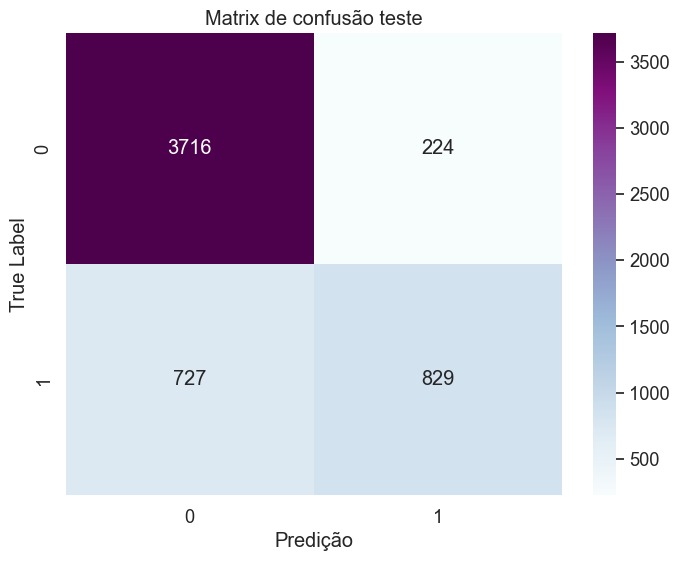

In [116]:
# Calculando a matriz de confusão (melhor foi o SVM com kernel RBF)
matriz_confusao = confusion_matrix(y_teste, predicoes_validacao_gb)

# Plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='BuPu', cbar=True)
plt.title('Matrix de confusão teste')
plt.xlabel('Predição')
plt.ylabel('True Label')
plt.show()

**5.1.b.** Trace a curva ROC sobre o conjunto de teste

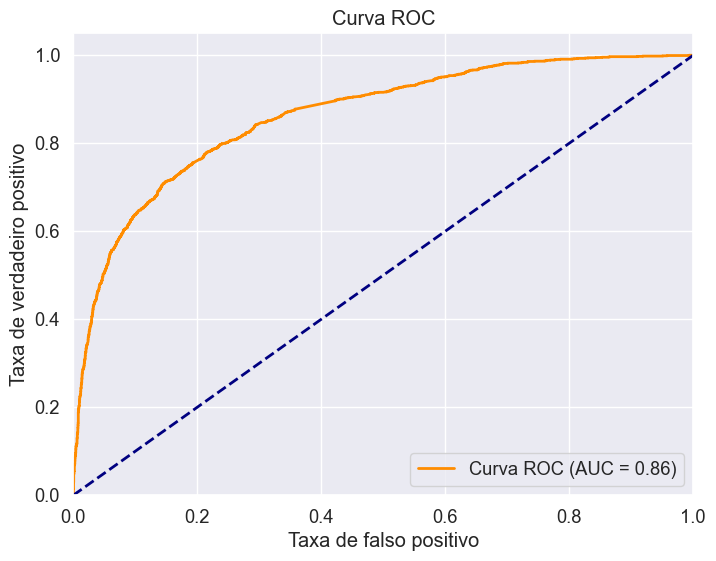

In [118]:
# Calculando as probabilidades das previsões
probabilidades = pipeline_gb.predict_proba(X_teste)
probabilidade_classe_positiva = probabilidades[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_teste, probabilidade_classe_positiva)

# Calculando a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

**5.2.** Utilizando o modelo Floresta Aleatória.

**a.** Encontre as 10 palavras mais importantes desse modelo (get_feature_names_out)

In [124]:
# Obtendo o modelo da pipeline
random_forest = pipeline_random_forest.named_steps['random_forest']

# Obtendo as importâncias das features
importancias_features = random_forest.feature_importances_

# Obtendo o nome das features (palavras)
nome_features = pipeline_random_forest.named_steps['count_vectorizer'].get_feature_names_out()

# Criando um dicionário para associar as importâncias das features aos nomes das features
importancias = dict(zip(nome_features, importancias_features))

# Ordenando as features pelo valor da importância e pegando as 10 principais
top_10_palavras_importantes = sorted(importancias, key=importancias.get, reverse=True)[:10]

# Imprimindo as 10 palavras mais importantes
print("As 10 palavras mais importantes são:")
for palavra in top_10_palavras_importantes:
    print(palavra)

As 10 palavras mais importantes são:
miss
sad
hate
sorry
bad
sucks
sick
not
my
to


**5.2.b.** Encontre 5 casos onde o modelo errou a classificação no conjunto de teste, mostrando a classificação real e a predita, assim como o tweet em questão.

In [125]:
# Criando um DataFrame para armazenar os tweets
resultados = pd.DataFrame({
    'Tweet': X_teste,
    'Classe Real': y_teste,
    'Previsão': predicoes_validacao_rf
})

# Filtrando os casos em que a previsão é diferente da classe real
casos_erro = resultados[resultados['Classe Real'] != resultados['Previsão']]

# Mostrando 5 casos onde o modelo errou a classificação
print("5 casos onde o modelo errou a classificação:")
for i, row in casos_erro.head(5).iterrows():
    print("Tweet:", row['Tweet'])
    print("Classe Real:", row['Classe Real'])
    print("Previsão:", row['Previsão'])
    print()

5 casos onde o modelo errou a classificação:
Tweet: There go my big plans... thanks, tonsils.
Classe Real: 1
Previsão: 0

Tweet: Now I want ice cream but it`s so expensive.
Classe Real: 1
Previsão: 0

Tweet: And it stopped raining.  Fuckingtastic! )
Classe Real: 1
Previsão: 0

Tweet: sitting in katies house with jo, the other two are away doing stuff, and i have swine flu  and bronchitis but thats a diff story.
Classe Real: 1
Previsão: 0

Tweet:  oh no, you`re gonna have to break up w/your ups guy when you move
Classe Real: 1
Previsão: 0



## 6 - Conclusão

**1.** Discorra sobre o que você aprendeu com essa atividade, bem como sobre eventuais dúvidas ou comentários


In [ ]:
"""
Posso dizer que aprendi bastante sobre como ajustar os hiperparâmetros e a importância que eles têm, achei interessante a forma
como muda os resultados ao se testar com os valores padrão e quando testamos alguns hiperparâmetros.
Uma dificuldade que tive foi de perceber quais hiperparâmetros testar inicialmente.
Achei bem interessante a biblioteca wordcloud, nunca tinha visto...
O modelo que tive mais dificuldade em entender foi justamente o que teve o melhor desempenho, SVM com kernel RBF.
Penso que fica mais evidente os conceitos enquanto é feito o trabalho do que apenas vendo em sala de aula.
"""

**6.2.** Quais limitações você enxerga na abordagem utilizada?

In [ ]:
"""
Pra mim pareceu que nem todos os modelos usados são os melhores para resolver esse problema dos tweets, mas acredito que faça parte
do aprendizado perceber isso, já que estamos estudando todos eles nesta disciplina...
"""